# Calibration of multiple parameters for ASPICS model, using ABC method

This jupyter notebook is based on the previous efforts from DyME and Prof Nick Malleson (University of Leeds)

- [RAMP-UA Initiative](https://github.com/Urban-Analytics/RAMP-UA/blob/d5973dff007645f1700cded93aaf72298ef84c61/experiments/calibration/abc-1.ipynb)

- [Calibrating Agent-Based Models Using Uncertainty Quantification Methods](https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipyn)

As SPC (Synthetic Population Catalyst) is a tool that helps urban modelling researchers to get synthetic population datasets at national level (currently limitated to England). This tool opens up new challenges/possibilities where external models (multi-level) like Agent-based models -ABM now can be tested in multi regions. However in models with location parameters striclty dependend on the population interactions, internal validation and calibrations process are seen as a relevant and requiered to properly tune this national behaivor. 

### ToDO to make progress in this experiment
- [X] Read the Synt Pop file - Translate to snaphot then ASPICS can read the new dataset.
- [] Read and plot the attributes we need, we could plot
- [] Read the baseline use as priors - Areas to test Leeds ( ideally West Yorkshire), Liverpool, Devon, Manchester (Grand Manchester)

## Background Concepts

- Uncertanity of ABM
- Methods for Calibration
- ABC

In [1]:
import math
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import random
from yaml import load, SafeLoader
sys.path.append('../')
from run_aspics import OpenCLRunner
from aspics.loader import setup_sim, create_params
from headless import run_headless
import synthpop_pb2
import convert_snapshot

The following function is based on [SPC scripts](https://github.com/alan-turing-institute/uatk-spc/blob/main/python/protobuf_to_csv.py) the idea is to read the .pb file created with the tool. However, we need to make a translation from the proto file to snapshot which will integarte the data in the way ASPICS need it.

## Read the baseline data. Defined as prior to calibrate the model to a given area
Real observations (number of cases, deaths or hospital admission in the given area)
They need to be made cumulative as this is how they will be compared to the model.

#### Rutland area as test run due it size
The data for no of cases and the gam_cases data were created using [Ramp-UA - Observation Data](https://github.com/Urban-Analytics/RAMP-UA/tree/master/experiments/calibration/observation_data)

In [2]:
# New per day:
gam_cases = pd.read_csv(os.path.join("baseline_data", "gam_manchester_cases.csv"), header=0, names=["Day", "Cases"], )
# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )
assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 34166


## Run ASPIC using the default parameters

The following cells provide a set of plots to define how the model run with the default parameters ( manually calibrated for Devon area). In this example we use Rutland.

Before everything, we need to translate the .pb (protobufer) file to the snapshot required by ASPCIS [Usage guide](docs/usage_guide.md). You need to do this one time. Once you created your synthetic population file, then run 'run ../convert_snapshot.py -i SPC_data/{YOUR_NEW_AREA}.pb -o ../data/snapshots/{YOUR_NEW_AREA}/cache.npz'


Great now we have the cache.npz file in `data/snapshots`


In [6]:
os.getcwd()

'/Users/fbenitez/PycharmProjects/uatk-aspics'

In [4]:
os.chdir("../") #Now we need to update the main directory then we can use aspics as the way was created.

In [19]:
PARAMETERS_FILE = 'config/Manchester.yml' # Reading the parameters file
with open(PARAMETERS_FILE, "r") as f:
    parameters = load(f, Loader=SafeLoader)

simulator, snapshot, study_area, iterations = setup_sim(parameters)  #Initial configuration, based on the parameters to run the model
summary, final_state = run_headless(simulator, snapshot, iterations, quiet=False, store_detailed_counts=True) #run the model in a headless mode

Running a manually added parameters simulation based on {'microsim': {'study-area': 'Manchester', 'iterations': 80, 'use-lockdown': False, 'start-date': 10, 'output': True, 'output-every-iteration': False, 'opencl-model': True, 'repetitions': 5}, 'microsim_calibration': {'hazard_individual_multipliers': {'presymptomatic': 1, 'asymptomatic': 0.75, 'symptomatic': 1.0}, 'hazard_location_multipliers': {'Retail': 1.0, 'PrimarySchool': 1.0, 'SecondarySchool': 1.0, 'Home': 1.0, 'Work': 1.0}, 'risk_multiplier': 1.0}, 'disease': {'current_risk_beta': 0.003, 'risk_cap': 5, 'seed_days': 10, 'exposed_dist': 'weibull', 'exposed_mean': 2.56, 'exposed_sd': 0.72, 'presymp_dist': 'weibull', 'presymp_mean': 2.3, 'presymp_sd': 0.35, 'infection_dist': 'lognormal', 'infection_mean': 7, 'infection_sd': 1.3, 'output_switch': True, 'rank_assign': False, 'local_outbreak_timestep': 7, 'local_outbreak': False, 'msoa_infect': 'E02004161', 'number_people_local': 100, 'local_prob_increase': 1.0, 'overweight_sympt_m

/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "
Running simulation: 100%|██████████| 80/80 [00:03<00:00, 22.61it/s]


Day 0
	Susceptible: 177129
	Exposed: 46
	Presymptomatic: 0
	Asymptomatic: 163
	Symptomatic: 88
	Recovered: 34
	Dead: 0

Day 1
	Susceptible: 177091
	Exposed: 69
	Presymptomatic: 4
	Asymptomatic: 142
	Symptomatic: 78
	Recovered: 76
	Dead: 0

Day 2
	Susceptible: 177051
	Exposed: 83
	Presymptomatic: 11
	Asymptomatic: 127
	Symptomatic: 64
	Recovered: 124
	Dead: 0

Day 3
	Susceptible: 177005
	Exposed: 86
	Presymptomatic: 20
	Asymptomatic: 132
	Symptomatic: 56
	Recovered: 161
	Dead: 0

Day 4
	Susceptible: 176935
	Exposed: 114
	Presymptomatic: 29
	Asymptomatic: 140
	Symptomatic: 50
	Recovered: 192
	Dead: 0

Day 5
	Susceptible: 176853
	Exposed: 148
	Presymptomatic: 34
	Asymptomatic: 144
	Symptomatic: 53
	Recovered: 228
	Dead: 0

Day 6
	Susceptible: 176763
	Exposed: 176
	Presymptomatic: 44
	Asymptomatic: 162
	Symptomatic: 67
	Recovered: 248
	Dead: 0

Day 7
	Susceptible: 176630
	Exposed: 237
	Presymptomatic: 57
	Asymptomatic: 189
	Symptomatic: 80
	Recovered: 267
	Dead: 0

Day 8
	Susceptible: 176

## Run ASPIC using the manually defined parameters


In [29]:
PARAMETERS_FILE = 'config/Manchester.yml' # Reading the parameters file
with open(PARAMETERS_FILE, "r") as f:
    parameters = load(f, Loader=SafeLoader)

In [30]:
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]

In [31]:
params_manual = OpenCLRunner.create_params_manually( parameters_file=PARAMETERS_FILE)

Creating parameters manually based on values from Notebook


In [32]:
REPETITIONS = 5
ITERATIONS = 100
STUDY_AREA = "Manchester"
OUTPUT = True
OUTPUT_EVERY_ITERATION = False
USE_LOCKDOWN = False
START_DATE = 10
#OBSERVATIONS IS DECLARED IN THE PREVIOUS CELL
USE_GPU = False
STORE_DETAILED_COUNTS = True
#PARAMETERS file IS DECLARED IN THE PREVIOUS CELL

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

In [33]:
OpenCLRunner.init(
    iterations = ITERATIONS,
    repetitions = REPETITIONS,
    study_area= STUDY_AREA,
    output=OUTPUT,
    output_every_iteration=OUTPUT_EVERY_ITERATION,
    use_lockdown=False,
    start_date=START_DATE,
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,
    #use_healthier_pop = False
)

In [13]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions to give a good baseline, initially suggested as 10
OpenCLRunner.update(store_detailed_counts=True)

In [34]:
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_aspics_with_params_abc({},PARAMETERS_FILE, return_full_details=True, quiet = False)

Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Running a simulation  {5680}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB


/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "

Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 177138
	Exposed: 37
	Presymptomatic: 0
	Asymptomatic: 151
	Symptomatic: 91
	Recovered: 43
	Dead: 0

Day 1
	Susceptible: 177109
	Exposed: 56
	Presymptomatic: 3
	Asymptomatic: 127
	Symptomatic: 71
	Recovered: 94
	Dead: 0

Day 2
	Susceptible: 177083
	Exposed: 54
	Presymptomatic: 13
	Asymptomatic: 120
	Symptomatic: 53
	Recovered: 137
	Dead: 0

Day 3
	Susceptible: 177051
	Exposed: 57
	Presymptomatic: 21
	Asymptomatic: 111
	Symptomatic: 43
	Recovered: 177
	Dead: 0

Day 4
	Susceptible: 177010
	Exposed: 74
	Presymptomatic: 19
	Asymptomatic: 108
	Symptomatic: 41
	Recovered: 208
	Dead: 0

Day 5
	Susceptible: 176973
	Exposed: 76
	Presymptomatic: 19
	Asymptomatic: 110
	Symptomatic: 48
	Recovered: 234
	Dead: 0

Day 6
	Susceptible: 176899
	Exposed: 118
	Presymptomatic: 25
	Asymptomatic: 119
	Symptomatic: 50
	Recovered: 249
	Dead: 0

Day 7
	Susceptible: 176844
	Exposed: 129
	Presymptomatic: 30
	Asymptomatic: 130
	Symptomatic: 57
	Recovered: 270
	Dead: 0

Day 8
	Susceptible: 17675


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 177136
	Exposed: 39
	Presymptomatic: 0
	Asymptomatic: 152
	Symptomatic: 83
	Recovered: 50
	Dead: 0

Day 1
	Susceptible: 177117
	Exposed: 50
	Presymptomatic: 2
	Asymptomatic: 124
	Symptomatic: 67
	Recovered: 100
	Dead: 0

Day 2
	Susceptible: 177098
	Exposed: 50
	Presymptomatic: 7
	Asymptomatic: 114
	Symptomatic: 54
	Recovered: 137
	Dead: 0

Day 3
	Susceptible: 177063
	Exposed: 55
	Presymptomatic: 17
	Asymptomatic: 106
	Symptomatic: 44
	Recovered: 175
	Dead: 0

Day 4
	Susceptible: 177007
	Exposed: 87
	Presymptomatic: 19
	Asymptomatic: 108
	Symptomatic: 34
	Recovered: 205
	Dead: 0

Day 5
	Susceptible: 176963
	Exposed: 101
	Presymptomatic: 22
	Asymptomatic: 109
	Symptomatic: 37
	Recovered: 228
	Dead: 0

Day 6
	Susceptible: 176914
	Exposed: 102
	Presymptomatic: 30
	Asymptomatic: 118
	Symptomatic: 43
	Recovered: 253
	Dead: 0

Day 7
	Susceptible: 176836
	Exposed: 128
	Presymptomatic: 36
	Asymptomatic: 139
	Symptomatic: 50
	Recovered: 271
	Dead: 0

Day 8
	Susceptible: 1767


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 177138
	Exposed: 37
	Presymptomatic: 0
	Asymptomatic: 149
	Symptomatic: 95
	Recovered: 41
	Dead: 0

Day 1
	Susceptible: 177109
	Exposed: 53
	Presymptomatic: 2
	Asymptomatic: 135
	Symptomatic: 74
	Recovered: 87
	Dead: 0

Day 2
	Susceptible: 177081
	Exposed: 58
	Presymptomatic: 7
	Asymptomatic: 126
	Symptomatic: 61
	Recovered: 127
	Dead: 0

Day 3
	Susceptible: 177048
	Exposed: 62
	Presymptomatic: 13
	Asymptomatic: 123
	Symptomatic: 51
	Recovered: 162
	Dead: 1

Day 4
	Susceptible: 177008
	Exposed: 76
	Presymptomatic: 16
	Asymptomatic: 119
	Symptomatic: 39
	Recovered: 201
	Dead: 1

Day 5
	Susceptible: 176949
	Exposed: 99
	Presymptomatic: 21
	Asymptomatic: 122
	Symptomatic: 35
	Recovered: 233
	Dead: 1

Day 6
	Susceptible: 176884
	Exposed: 118
	Presymptomatic: 27
	Asymptomatic: 135
	Symptomatic: 37
	Recovered: 258
	Dead: 1

Day 7
	Susceptible: 176797
	Exposed: 152
	Presymptomatic: 34
	Asymptomatic: 150
	Symptomatic: 49
	Recovered: 277
	Dead: 1

Day 8
	Susceptible: 176712


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 177139
	Exposed: 36
	Presymptomatic: 0
	Asymptomatic: 152
	Symptomatic: 98
	Recovered: 35
	Dead: 0

Day 1
	Susceptible: 177112
	Exposed: 53
	Presymptomatic: 5
	Asymptomatic: 131
	Symptomatic: 84
	Recovered: 75
	Dead: 0

Day 2
	Susceptible: 177083
	Exposed: 54
	Presymptomatic: 5
	Asymptomatic: 129
	Symptomatic: 73
	Recovered: 116
	Dead: 0

Day 3
	Susceptible: 177046
	Exposed: 62
	Presymptomatic: 11
	Asymptomatic: 120
	Symptomatic: 62
	Recovered: 159
	Dead: 0

Day 4
	Susceptible: 177008
	Exposed: 76
	Presymptomatic: 17
	Asymptomatic: 112
	Symptomatic: 41
	Recovered: 206
	Dead: 0

Day 5
	Susceptible: 176959
	Exposed: 92
	Presymptomatic: 19
	Asymptomatic: 117
	Symptomatic: 39
	Recovered: 234
	Dead: 0

Day 6
	Susceptible: 176910
	Exposed: 100
	Presymptomatic: 22
	Asymptomatic: 129
	Symptomatic: 43
	Recovered: 256
	Dead: 0

Day 7
	Susceptible: 176847
	Exposed: 107
	Presymptomatic: 29
	Asymptomatic: 156
	Symptomatic: 49
	Recovered: 272
	Dead: 0

Day 8
	Susceptible: 176745


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]


Day 0
	Susceptible: 177134
	Exposed: 41
	Presymptomatic: 0
	Asymptomatic: 152
	Symptomatic: 84
	Recovered: 48
	Dead: 1

Day 1
	Susceptible: 177104
	Exposed: 62
	Presymptomatic: 4
	Asymptomatic: 137
	Symptomatic: 73
	Recovered: 79
	Dead: 1

Day 2
	Susceptible: 177070
	Exposed: 69
	Presymptomatic: 13
	Asymptomatic: 132
	Symptomatic: 60
	Recovered: 115
	Dead: 1

Day 3
	Susceptible: 177034
	Exposed: 71
	Presymptomatic: 17
	Asymptomatic: 127
	Symptomatic: 53
	Recovered: 157
	Dead: 1

Day 4
	Susceptible: 176984
	Exposed: 90
	Presymptomatic: 15
	Asymptomatic: 123
	Symptomatic: 47
	Recovered: 200
	Dead: 1

Day 5
	Susceptible: 176928
	Exposed: 114
	Presymptomatic: 15
	Asymptomatic: 127
	Symptomatic: 51
	Recovered: 224
	Dead: 1

Day 6
	Susceptible: 176867
	Exposed: 118
	Presymptomatic: 28
	Asymptomatic: 150
	Symptomatic: 41
	Recovered: 255
	Dead: 1

Day 7
	Susceptible: 176751
	Exposed: 181
	Presymptomatic: 39
	Asymptomatic: 160
	Symptomatic: 53
	Recovered: 275
	Dead: 1

Day 8
	Susceptible: 1766

fitness: 78951.19640664099


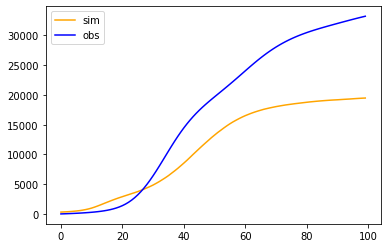

In [35]:
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim", color="orange")
ax.plot(x, obs0, label="obs", color="blue")
ax.legend()